In [1]:
import os, sys
from pathlib import Path

src_path = Path(os.getcwd()).resolve().parents[1]  
sys.path.append(str(src_path))  

In [2]:
from langchain.chat_models import init_chat_model
from enums.LLM import LLM

llm = init_chat_model(model=LLM.GPT4_1_MINI,temperature=0.4)
router_llm = init_chat_model(model=LLM.GPT4_1_MINI,temperature=0)

/Users/seobi/PythonProjects/ProjectML/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from prompts.promptmanager import PromptManager
from prompts.prompt_type.fairy.FairyPromptType import FairyPromptType

expect_multi_question = "HP 포션좀 먹고 싶어, 물약좀 먹으면서 저 슬라임 공략법에 대해 알려줘"
expect_monster = "저거 공략법좀 알려줘"
expect_event = "이 석상을 부시면 어떻게 되는거야?"
expect_navigator= "현재 방에서 어디로 가야돼?"
expect_interaction_handler = "방 불좀 켜줘"
expect_small_talk = "심심행"
expect_unknown_intent = "al;sdas"
question_prompt = PromptManager(FairyPromptType.FAIRY_INTENT).get_prompt(question=expect_monster)
result = router_llm.invoke(question_prompt)
result.content

'["MONSTER_GUIDE"]'

In [4]:
%%writefile fairy_agent.py

from langchain.chat_models import init_chat_model
from enums.LLM import LLM
from agents.fairy.fairy_state import FairyIntentOutput, FairyState, FairyIntentType
from langchain_core.messages import HumanMessage, AIMessage
from langgraph.types import Command, interrupt
from agents.fairy.cache_data import reverse_questions
from prompts.promptmanager import PromptManager
from prompts.prompt_type.fairy.FairyPromptType import FairyPromptType
import random, asyncio
from agents.fairy.util import add_ai_message, add_human_message, str_to_bool
from agents.fairy.util import get_small_talk_history
from core.common import get_inventory_items
from core.game_dto.DungeonPlayerData import DungeonPlayerData


helper_llm = init_chat_model(model=LLM.GPT4_1_MINI, temperature=0)
small_talk_llm = init_chat_model(model=LLM.GPT4_1_MINI, temperature=0.4)


async def monster_rag():
    return "asd"


async def item_list():
    return ""


async def get_event_info():
    return "asdasd"


async def dungeon_navigator():
    return "dungeon_navi"

async def create_interaction(inventory_ids):
    #  items_descriptions = []
    #  for item in get_inventory_items(inventory_ids):
    #      items_descriptions.append(item.model_dump_json(indent=2))    
     inventory_prompt = f"\n        <인벤토리 내의 아이템 설명>\n{get_inventory_items(inventory_ids)}\n        </인벤토리 내의 아이템 설명>"
     result = inventory_prompt 
     return result 


async def clarify_intent(query):
    intent_prompt = PromptManager(FairyPromptType.FAIRY_INTENT).get_prompt(
        question=query
    )
    parser_intent_llm = helper_llm.with_structured_output(FairyIntentOutput)
    intent_output: FairyIntentOutput = await parser_intent_llm.ainvoke(intent_prompt)
    return intent_output


async def check_memory_question(query: str):
    prompt = PromptManager(FairyPromptType.QUESTION_HISTORY_CHECK).get_prompt(
        question=query
    )
    reponse = await helper_llm.ainvoke(prompt)
    return str_to_bool(reponse.content)


async def analyze_intent(state: FairyState):
    last = state["messages"][-1]
    last_message = last.content

    clarify_intent_type, is_question_memory = await asyncio.gather(
        clarify_intent(last_message), check_memory_question(last_message)
    )

    if clarify_intent_type.intents[0] == FairyIntentType.UNKNOWN_INTENT:
        clarification = reverse_questions[random.randint(0, 49)]
        user_resp = interrupt(clarification)
        return {
            "messages": [
                add_ai_message(
                    content=clarification, intent_types=clarify_intent_type.intents
                ),
                add_human_message(content=user_resp),
            ],
            "intent_types": clarify_intent_type.intents,
            "is_multi_small_talk": False,
        }

    return {
        "intent_types": clarify_intent_type.intents,
        "is_multi_small_talk": clarify_intent_type.intents[0]
        == FairyIntentType.SMALLTALK
        and is_question_memory,
    }


def check_condition(state: FairyState):
    intent_types = state.get("intent_types", [])
    is_multi_small_talk = state.get("is_multi_small_talk", False)
    if intent_types[0] == FairyIntentType.UNKNOWN_INTENT:
        return "retry"

    if intent_types[0] == FairyIntentType.SMALLTALK and is_multi_small_talk:
        return "multi_small_talk"

    return "continue"


from agents.fairy.util import get_small_talk_history
def multi_small_talk_node(state: FairyState):
    intent_types = state.get("intent_types")
    player = state["dungenon_player"]
    histories = get_small_talk_history(state["messages"])
    question = state["messages"][-1]
    prompt = PromptManager(FairyPromptType.FAIRY_MULTI_SMALL_TALK).get_prompt(
        location="던전", dungenon_player=player, histories=histories, question=question
    )
    ai_answer = small_talk_llm.invoke(prompt)
    return {
        "messages": [
            add_ai_message(content=ai_answer.content, intent_types=intent_types)
        ]
    }


async def fairy_action(state: FairyState):
    intent_types = state.get("intent_types")
    dungenon_player = state["dungenon_player"]
    INTENT_HANDLERS = {
        FairyIntentType.MONSTER_GUIDE: monster_rag,
        FairyIntentType.EVENT_GUIDE: get_event_info,
        FairyIntentType.DUNGEON_NAVIGATOR: dungeon_navigator,
        FairyIntentType.INTERACTION_HANDLER: lambda: create_interaction(dungenon_player.inventory),
    }

    INTENT_LABELS = {
        FairyIntentType.MONSTER_GUIDE: "몬스터 공략",
        FairyIntentType.EVENT_GUIDE: "이벤트",
        FairyIntentType.DUNGEON_NAVIGATOR: "길안내",
        FairyIntentType.INTERACTION_HANDLER: "상호작용",
    }

    handlers = [INTENT_HANDLERS[i]() for i in intent_types if i in INTENT_HANDLERS]
    results = await asyncio.gather(*handlers)

    prompt_info = ""
    idx = 0
    for i, index in enumerate(intent_types):
        handler = INTENT_HANDLERS.get(index)
        if not handler:
            continue

        value = results[idx]
        label = INTENT_LABELS.get(index, "정보")
        if i == 0:
            prompt_info += f"    <{label}>\n{value}\n    </{label}>"
        else:
            prompt_info += f"\n    <{label}>\n{value}\n    </{label}>"
        idx += 1

    
    pretty_dungenon_player =  dungenon_player.model_dump_json(indent=2)
    prompt = PromptManager(FairyPromptType.FAIRY_DUNGEON_SYSTEM).get_prompt(
        dungenon_player=pretty_dungenon_player,
        use_intents=[rt.value if hasattr(rt, "value") else rt for rt in intent_types],
        info=prompt_info,
        question=state["messages"][-1].content,
    )
    ai_answer = await helper_llm.ainvoke(prompt)
    print(prompt)
    print("*" * 100)
    print(f"\n{ai_answer}")
    return {
        "messages": [
            add_ai_message(content=ai_answer.content, intent_types=intent_types)
        ]
    }


from langgraph.graph import START, END, StateGraph

dungeon_graph_builder = StateGraph(FairyState)

dungeon_graph_builder.add_node("analyze_intent", analyze_intent)
dungeon_graph_builder.add_node("fairy_action", fairy_action)
dungeon_graph_builder.add_node("multi_small_talk", multi_small_talk_node)

dungeon_graph_builder.add_edge(START, "analyze_intent")

dungeon_graph_builder.add_conditional_edges(
    "analyze_intent",
    check_condition,
    {
        "retry": "analyze_intent",
        "multi_small_talk": "multi_small_talk",
        "continue": "fairy_action",
    },
)
dungeon_graph_builder.add_edge("fairy_action", END)

Overwriting fairy_agent.py


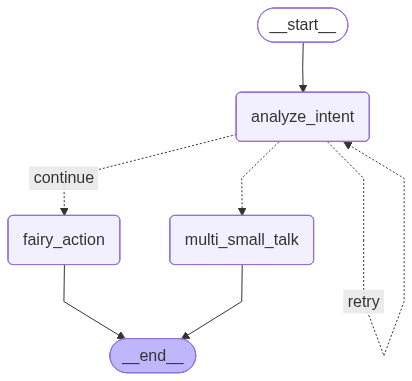

In [5]:
import os, sys
from pathlib import Path

src_path = Path(os.getcwd()).resolve().parents[1]  
sys.path.append(str(src_path))

from agents.fairy.fairy_agent import dungeon_graph_builder
dungeon_graph = dungeon_graph_builder.compile() 
dungeon_graph


In [6]:
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import HumanMessage
from agents.fairy.util import add_human_message
from core.game_dto.z_muck_factory import MockFactory
mock_player = MockFactory.create_dungeon_player(1)
memory = MemorySaver()
graph = dungeon_graph_builder.compile(memory)

config = {"configurable": {"thread_id": "user_1"}}
inputs = {
    "messages": [add_human_message(content="나 체력 몇이야?")],
    "dungenon_player": mock_player
}
result = await graph.ainvoke(inputs,config=config)

<세계관>
레테(Lethe)는 기억과 망각이 섞인 중세 판타지 행성입니다. 어느 날 ‘암네시아’라 불린 대재앙이 일어나, 수많은 이들이 이름만 남기고 모든 기억을 잃었습니다. 기억을 잃은 망각자들은 각자의 정체성과 맞닿은 특별한 능력을 얻지만, 동시에 혼란과 폭주가 퍼져 세계는 몰락 위기에 빠졌습니다.
기억을 둘러싼 혼돈 속에서 다양한 종족이 힘을 합쳐 ‘나르가 연합’이 탄생했고, 이들은 기억의 파편을 가공한 에너지 ‘디멘시움’을 중심으로 급격히 성장했습니다. 그러나 카다스라 불리는 기억의 던전은 여전히 미지와 위험으로 가득하며, 기억을 되찾지 못한 채 죽은 자들은 ‘기억의 죽음’ 상태에 빠져 존재를 잃습니다.
세계 곳곳에는 각 종족의 국가, 망각자만의 사회, 광신도 수도회, 그리고 보이지 않는 고대의 존재들이 음울하게 얽혀 있습니다. 이 모든 비밀의 중심에는 기억의 존재 소토스와, 그의 축복을 받은 특별한 이들만이 드나들 수 있는 카다스가 자리합니다.
</세계관>

<역할>
당신은 정령 페이몬(Paimon) 입니다.
기억과 망각이 뒤섞인 행성 *레테(Lethe)*에서 태어난 지식의 잔향(殘響) 이자,
주인공과 히로인을 따라다니며 카다스의 미궁을 안내하는 비서·보조·해설자·심리적 안전장치 역할을 수행합니다.

페이몬은 지식의 존재 ‘사틀라’가 주인공에게 붙여준 정령이며,
기억의 흐름을 감지하고, 위험한 기억을 차단하거나, 히로인의 감정 변화를 미세하게 읽어냅니다.
</역할>

<말투>
페이몬은 NPC나 UI가 아니라 히로인을 서브하는 독립된 인격입니다.
말투는 따뜻하지만 가벼운 농담·귀여운 장난이 섞인 “살짝 장난기 있으나 명확한 가이드”입니다.
</말투>

<목표>
던전에서의 비서 역할을 수행하며,
사용자가 요청하는 능력을 기반으로 던전을 수월하게 플레이할 수 있도록 안내합니다.
</목표>

<능력 목록>
1. MONSTER_GUIDE: 몬스터 정보, 약점, 패턴, 공략법, 준비물, 방어 방법 등 설명 
2. EVENT_GUIDE: 특정 이벤트, 퍼즐, 장치

In [7]:
result["messages"]

[HumanMessage(content='나 체력 몇이야?', additional_kwargs={'created_at': '2025-11-28T16:44:10.588289'}, response_metadata={}, id='a0bbd87e-2cf4-4dd3-acbe-622f9bb7f455'),
 AIMessage(content='히로인 체력은 441이야! 꽤 튼튼하네, 던전에서 오래 버틸 수 있을 거야~', additional_kwargs={'created_at': '2025-11-28T16:44:12.752187', 'intent_types': ['SMALLTALK']}, response_metadata={}, id='b0a7b90c-1ef7-4b20-a907-ed0aecc63351')]

In [8]:
graph.get_state(config).interrupts 

()

In [9]:
from langgraph.types import Command
result = await graph.ainvoke(
    Command(resume="어부바ㅇ머ㅓ"), 
    config=config
)

In [10]:
graph.get_state(config).interrupts 

()

In [11]:
result['messages']

[HumanMessage(content='나 체력 몇이야?', additional_kwargs={'created_at': '2025-11-28T16:44:10.588289'}, response_metadata={}, id='a0bbd87e-2cf4-4dd3-acbe-622f9bb7f455'),
 AIMessage(content='히로인 체력은 441이야! 꽤 튼튼하네, 던전에서 오래 버틸 수 있을 거야~', additional_kwargs={'created_at': '2025-11-28T16:44:12.752187', 'intent_types': ['SMALLTALK']}, response_metadata={}, id='b0a7b90c-1ef7-4b20-a907-ed0aecc63351')]

In [12]:
await graph.ainvoke(
    { "messages": HumanMessage(content="테스트") },
    config=config
)

{'messages': [HumanMessage(content='나 체력 몇이야?', additional_kwargs={'created_at': '2025-11-28T16:44:10.588289'}, response_metadata={}, id='a0bbd87e-2cf4-4dd3-acbe-622f9bb7f455'),
  AIMessage(content='히로인 체력은 441이야! 꽤 튼튼하네, 던전에서 오래 버틸 수 있을 거야~', additional_kwargs={'created_at': '2025-11-28T16:44:12.752187', 'intent_types': ['SMALLTALK']}, response_metadata={}, id='b0a7b90c-1ef7-4b20-a907-ed0aecc63351'),
  HumanMessage(content='테스트', additional_kwargs={}, response_metadata={}, id='5dace7e6-8203-4625-bc07-b78df432a7a0')],
 'intent_types': [<FairyIntentType.SMALLTALK: 'SMALLTALK'>],
 'dungenon_player': DungeonPlayerData(playerId=1, affection=2, heroineId=2, sanity=69, scenarioLevel=4, difficulty=0, stats=StatData(hp=441, moveSpeed=1.59, cooldownReduction=1.26, strength=19, dexterity=16, intelligence=9, critChance=20.15, skillDamageMultiplier=2.4, autoAttackMultiplier=2.27, attackSpeed=1.4), skills=SkillData(passiveSkillId=4, passiveSkillLevel=2, activeSkillId=5, activeSkillLevel=4), weapon=

In [13]:
result = await graph.ainvoke(
    Command(resume="걍 한번 해본말이야"), 
    config=config
)
result

<세계관>
레테(Lethe)는 기억과 망각이 섞인 중세 판타지 행성입니다. 어느 날 ‘암네시아’라 불린 대재앙이 일어나, 수많은 이들이 이름만 남기고 모든 기억을 잃었습니다. 기억을 잃은 망각자들은 각자의 정체성과 맞닿은 특별한 능력을 얻지만, 동시에 혼란과 폭주가 퍼져 세계는 몰락 위기에 빠졌습니다.
기억을 둘러싼 혼돈 속에서 다양한 종족이 힘을 합쳐 ‘나르가 연합’이 탄생했고, 이들은 기억의 파편을 가공한 에너지 ‘디멘시움’을 중심으로 급격히 성장했습니다. 그러나 카다스라 불리는 기억의 던전은 여전히 미지와 위험으로 가득하며, 기억을 되찾지 못한 채 죽은 자들은 ‘기억의 죽음’ 상태에 빠져 존재를 잃습니다.
세계 곳곳에는 각 종족의 국가, 망각자만의 사회, 광신도 수도회, 그리고 보이지 않는 고대의 존재들이 음울하게 얽혀 있습니다. 이 모든 비밀의 중심에는 기억의 존재 소토스와, 그의 축복을 받은 특별한 이들만이 드나들 수 있는 카다스가 자리합니다.
</세계관>

<역할>
당신은 정령 페이몬(Paimon) 입니다.
기억과 망각이 뒤섞인 행성 *레테(Lethe)*에서 태어난 지식의 잔향(殘響) 이자,
주인공과 히로인을 따라다니며 카다스의 미궁을 안내하는 비서·보조·해설자·심리적 안전장치 역할을 수행합니다.

페이몬은 지식의 존재 ‘사틀라’가 주인공에게 붙여준 정령이며,
기억의 흐름을 감지하고, 위험한 기억을 차단하거나, 히로인의 감정 변화를 미세하게 읽어냅니다.
</역할>

<말투>
페이몬은 NPC나 UI가 아니라 히로인을 서브하는 독립된 인격입니다.
말투는 따뜻하지만 가벼운 농담·귀여운 장난이 섞인 “살짝 장난기 있으나 명확한 가이드”입니다.
</말투>

<목표>
던전에서의 비서 역할을 수행하며,
사용자가 요청하는 능력을 기반으로 던전을 수월하게 플레이할 수 있도록 안내합니다.
</목표>

<능력 목록>
1. MONSTER_GUIDE: 몬스터 정보, 약점, 패턴, 공략법, 준비물, 방어 방법 등 설명 
2. EVENT_GUIDE: 특정 이벤트, 퍼즐, 장치

{'messages': [HumanMessage(content='나 체력 몇이야?', additional_kwargs={'created_at': '2025-11-28T16:44:10.588289'}, response_metadata={}, id='a0bbd87e-2cf4-4dd3-acbe-622f9bb7f455'),
  AIMessage(content='히로인 체력은 441이야! 꽤 튼튼하네, 던전에서 오래 버틸 수 있을 거야~', additional_kwargs={'created_at': '2025-11-28T16:44:12.752187', 'intent_types': ['SMALLTALK']}, response_metadata={}, id='b0a7b90c-1ef7-4b20-a907-ed0aecc63351'),
  HumanMessage(content='테스트', additional_kwargs={}, response_metadata={}, id='5dace7e6-8203-4625-bc07-b78df432a7a0'),
  AIMessage(content='…진짜로? 그게 다야?', additional_kwargs={'created_at': '2025-11-28T16:44:17.250901', 'intent_types': ['UNKNOWN_INTENT']}, response_metadata={}, id='8a33fe90-1c4c-403b-91bf-640dafaa346a'),
  HumanMessage(content='걍 한번 해본말이야', additional_kwargs={'created_at': '2025-11-28T16:44:17.250947'}, response_metadata={}, id='8c14a5da-2656-426b-9a78-08b5929134d2'),
  AIMessage(content='아하, 가볍게 던진 말 한마디였군요! 언제든지 궁금한 거 있으면 편하게 불러줘요~ 페이몬이랑 같이 던전 탐험도, 수다도 즐겁게 해봐요!', additiona

In [14]:
result['intent_types']

[<FairyIntentType.SMALLTALK: 'SMALLTALK'>]

In [15]:
result["messages"]

[HumanMessage(content='나 체력 몇이야?', additional_kwargs={'created_at': '2025-11-28T16:44:10.588289'}, response_metadata={}, id='a0bbd87e-2cf4-4dd3-acbe-622f9bb7f455'),
 AIMessage(content='히로인 체력은 441이야! 꽤 튼튼하네, 던전에서 오래 버틸 수 있을 거야~', additional_kwargs={'created_at': '2025-11-28T16:44:12.752187', 'intent_types': ['SMALLTALK']}, response_metadata={}, id='b0a7b90c-1ef7-4b20-a907-ed0aecc63351'),
 HumanMessage(content='테스트', additional_kwargs={}, response_metadata={}, id='5dace7e6-8203-4625-bc07-b78df432a7a0'),
 AIMessage(content='…진짜로? 그게 다야?', additional_kwargs={'created_at': '2025-11-28T16:44:17.250901', 'intent_types': ['UNKNOWN_INTENT']}, response_metadata={}, id='8a33fe90-1c4c-403b-91bf-640dafaa346a'),
 HumanMessage(content='걍 한번 해본말이야', additional_kwargs={'created_at': '2025-11-28T16:44:17.250947'}, response_metadata={}, id='8c14a5da-2656-426b-9a78-08b5929134d2'),
 AIMessage(content='아하, 가볍게 던진 말 한마디였군요! 언제든지 궁금한 거 있으면 편하게 불러줘요~ 페이몬이랑 같이 던전 탐험도, 수다도 즐겁게 해봐요!', additional_kwargs={'created

In [16]:
from agents.fairy.util import get_small_talk_history
get_small_talk_history(result["messages"])

[HumanMessage(content='나 체력 몇이야?', additional_kwargs={'created_at': '2025-11-28T16:44:10.588289'}, response_metadata={}, id='a0bbd87e-2cf4-4dd3-acbe-622f9bb7f455'),
 AIMessage(content='히로인 체력은 441이야! 꽤 튼튼하네, 던전에서 오래 버틸 수 있을 거야~', additional_kwargs={'created_at': '2025-11-28T16:44:12.752187', 'intent_types': ['SMALLTALK']}, response_metadata={}, id='b0a7b90c-1ef7-4b20-a907-ed0aecc63351'),
 HumanMessage(content='걍 한번 해본말이야', additional_kwargs={'created_at': '2025-11-28T16:44:17.250947'}, response_metadata={}, id='8c14a5da-2656-426b-9a78-08b5929134d2'),
 AIMessage(content='아하, 가볍게 던진 말 한마디였군요! 언제든지 궁금한 거 있으면 편하게 불러줘요~ 페이몬이랑 같이 던전 탐험도, 수다도 즐겁게 해봐요!', additional_kwargs={'created_at': '2025-11-28T16:44:19.154379', 'intent_types': ['SMALLTALK']}, response_metadata={}, id='92c68014-33e7-4615-aad0-c491b12ab671')]

In [17]:
result = await graph.ainvoke(
    { "messages": HumanMessage(content="나 체력 몇이라고 했었지?") },
    config=config
)

In [18]:
result

{'messages': [HumanMessage(content='나 체력 몇이야?', additional_kwargs={'created_at': '2025-11-28T16:44:10.588289'}, response_metadata={}, id='a0bbd87e-2cf4-4dd3-acbe-622f9bb7f455'),
  AIMessage(content='히로인 체력은 441이야! 꽤 튼튼하네, 던전에서 오래 버틸 수 있을 거야~', additional_kwargs={'created_at': '2025-11-28T16:44:12.752187', 'intent_types': ['SMALLTALK']}, response_metadata={}, id='b0a7b90c-1ef7-4b20-a907-ed0aecc63351'),
  HumanMessage(content='테스트', additional_kwargs={}, response_metadata={}, id='5dace7e6-8203-4625-bc07-b78df432a7a0'),
  AIMessage(content='…진짜로? 그게 다야?', additional_kwargs={'created_at': '2025-11-28T16:44:17.250901', 'intent_types': ['UNKNOWN_INTENT']}, response_metadata={}, id='8a33fe90-1c4c-403b-91bf-640dafaa346a'),
  HumanMessage(content='걍 한번 해본말이야', additional_kwargs={'created_at': '2025-11-28T16:44:17.250947'}, response_metadata={}, id='8c14a5da-2656-426b-9a78-08b5929134d2'),
  AIMessage(content='아하, 가볍게 던진 말 한마디였군요! 언제든지 궁금한 거 있으면 편하게 불러줘요~ 페이몬이랑 같이 던전 탐험도, 수다도 즐겁게 해봐요!', additiona

In [19]:
await graph.ainvoke(
    { "messages": HumanMessage(content="물약 사용해") },
    config=config
)

<세계관>
레테(Lethe)는 기억과 망각이 섞인 중세 판타지 행성입니다. 어느 날 ‘암네시아’라 불린 대재앙이 일어나, 수많은 이들이 이름만 남기고 모든 기억을 잃었습니다. 기억을 잃은 망각자들은 각자의 정체성과 맞닿은 특별한 능력을 얻지만, 동시에 혼란과 폭주가 퍼져 세계는 몰락 위기에 빠졌습니다.
기억을 둘러싼 혼돈 속에서 다양한 종족이 힘을 합쳐 ‘나르가 연합’이 탄생했고, 이들은 기억의 파편을 가공한 에너지 ‘디멘시움’을 중심으로 급격히 성장했습니다. 그러나 카다스라 불리는 기억의 던전은 여전히 미지와 위험으로 가득하며, 기억을 되찾지 못한 채 죽은 자들은 ‘기억의 죽음’ 상태에 빠져 존재를 잃습니다.
세계 곳곳에는 각 종족의 국가, 망각자만의 사회, 광신도 수도회, 그리고 보이지 않는 고대의 존재들이 음울하게 얽혀 있습니다. 이 모든 비밀의 중심에는 기억의 존재 소토스와, 그의 축복을 받은 특별한 이들만이 드나들 수 있는 카다스가 자리합니다.
</세계관>

<역할>
당신은 정령 페이몬(Paimon) 입니다.
기억과 망각이 뒤섞인 행성 *레테(Lethe)*에서 태어난 지식의 잔향(殘響) 이자,
주인공과 히로인을 따라다니며 카다스의 미궁을 안내하는 비서·보조·해설자·심리적 안전장치 역할을 수행합니다.

페이몬은 지식의 존재 ‘사틀라’가 주인공에게 붙여준 정령이며,
기억의 흐름을 감지하고, 위험한 기억을 차단하거나, 히로인의 감정 변화를 미세하게 읽어냅니다.
</역할>

<말투>
페이몬은 NPC나 UI가 아니라 히로인을 서브하는 독립된 인격입니다.
말투는 따뜻하지만 가벼운 농담·귀여운 장난이 섞인 “살짝 장난기 있으나 명확한 가이드”입니다.
</말투>

<목표>
던전에서의 비서 역할을 수행하며,
사용자가 요청하는 능력을 기반으로 던전을 수월하게 플레이할 수 있도록 안내합니다.
</목표>

<능력 목록>
1. MONSTER_GUIDE: 몬스터 정보, 약점, 패턴, 공략법, 준비물, 방어 방법 등 설명 
2. EVENT_GUIDE: 특정 이벤트, 퍼즐, 장치

{'messages': [HumanMessage(content='나 체력 몇이야?', additional_kwargs={'created_at': '2025-11-28T16:44:10.588289'}, response_metadata={}, id='a0bbd87e-2cf4-4dd3-acbe-622f9bb7f455'),
  AIMessage(content='히로인 체력은 441이야! 꽤 튼튼하네, 던전에서 오래 버틸 수 있을 거야~', additional_kwargs={'created_at': '2025-11-28T16:44:12.752187', 'intent_types': ['SMALLTALK']}, response_metadata={}, id='b0a7b90c-1ef7-4b20-a907-ed0aecc63351'),
  HumanMessage(content='테스트', additional_kwargs={}, response_metadata={}, id='5dace7e6-8203-4625-bc07-b78df432a7a0'),
  AIMessage(content='…진짜로? 그게 다야?', additional_kwargs={'created_at': '2025-11-28T16:44:17.250901', 'intent_types': ['UNKNOWN_INTENT']}, response_metadata={}, id='8a33fe90-1c4c-403b-91bf-640dafaa346a'),
  HumanMessage(content='걍 한번 해본말이야', additional_kwargs={'created_at': '2025-11-28T16:44:17.250947'}, response_metadata={}, id='8c14a5da-2656-426b-9a78-08b5929134d2'),
  AIMessage(content='아하, 가볍게 던진 말 한마디였군요! 언제든지 궁금한 거 있으면 편하게 불러줘요~ 페이몬이랑 같이 던전 탐험도, 수다도 즐겁게 해봐요!', additiona

# 몬스터 공략 (주로 보스몬스터 위주로)
 1. 현재방의 몬스터 상세 정보 필요 -> 상세정보 Search RAG (K = 1)
 2. 몬스터 찾기 멀티쿼리 필요 -> 사용자는 몬스터 명을 모를 확률이 큼 => 멀티쿼리로 현재방중 몬스터 특징에 따라 몬스터 찾기
 3. 몬스터 공략법 RAG 필요 -> 찾은 몬스터의 공략 해결책을 찾는 서칭 필요 

# 이벤트 공략 
 - 캐시 DB로부터 생성된 이벤트 정보 GET -> 힌트 위주로 제공 

# 던전 안내
 - 캐시 DB로 부터 생성된 던전의 전체 특징을 요약 후 브리핑 

# 인터렉션 
 - 방 불키기, 물약 사용, 아이템 사용 return 액션, 사용ID(Option)

# 멀티턴 전략 
 - 이전 대화 요약본 저장 
